In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
load_dataset = False
load_model = False

# Dataset preparing

In [3]:
from dataset.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd

In [58]:
true_dist_size = 10000
dataset = FactDatasetGenerator(number_person=1000,  distribution="zipf", dataset_folder='./dataset/data/', food_list_name="food_list_small.txt",true_dist_size=true_dist_size, experiment_path="experiment/medium_dataset/data/")

In [59]:
if load_dataset:
    dataset.load_dataset()
    true_dist = dataset.true_dist 
    training_data = dataset.training_data
else:
    # Generate all possible facts
    temp = dataset.generate_all_possibilities()
    # Sample true dist (zipf)
    true_dist = dataset.generate_true_dist()
    # Sample training data uniformly, %80 of true dist
    training_dataset_size = int(0.3 * true_dist_size)
    training_data = dataset.sample_training_data(training_dataset_size,true_dist.tolist())
    print(dataset.vocab_size)
    print(len(temp))

1098
101000


In [60]:
true_dist_df = pd.DataFrame(true_dist,columns=["facts"])

In [61]:
true_dist_df

,facts
0,"Derek,tuna tartare"
1,"Gibby,lobster roll sandwich"
2,"Amalee,lobster bisque"
3,"Robbi,greek salad"
4,"Perrine,bread pudding"
...,...
9995,"Lesley,filet mignon"
9996,"Koressa,shrimp and grits"
9997,"Hervey,grilled cheese sandwich"
9998,"Lela,mussels"


In [62]:
true_duplicates_count = true_dist_df.groupby(list(true_dist_df.columns)).size().reset_index(name='count_true')


In [63]:
true_duplicates_count

,facts,count_true
0,"Abbe,beef carpaccio",1
1,"Abbe,creme brulee",1
2,"Abbe,frozen yogurt",1
3,"Abbe,ramen",1
4,"Abbi,crab cakes",1
...,...,...
4238,"Zita,breakfast burrito",1
4239,"Zita,red velvet cake",3
4240,"Zorine,club sandwich",1
4241,"Zorine,hamburger",1


In [64]:
training_dist_df = pd.DataFrame(training_data,columns=["facts"])
training_duplicates_count = training_dist_df.groupby(list(training_dist_df.columns)).size().reset_index(name='count_train')

In [65]:
training_duplicates_count

,facts,count_train
0,"Abbe,frozen yogurt",1
1,"Abbi,crab cakes",1
2,"Abbi,grilled cheese sandwich",1
3,"Abbi,spaghetti bolognese",1
4,"Abbie,apple pie",1
...,...,...
1591,"Zechariah,huevos rancheros",3
1592,"Zedekiah,beef carpaccio",1
1593,"Zedekiah,pho",1
1594,"Zedekiah,spring rolls",1


In [66]:
import torch
## get the training  datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.tokenized_training_data]


In [67]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [68]:
## import mingpt
sys.path.append('minGPT/')
from mingpt.model import GPT
from mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocab_size
model_config.model_type = None
model_config.block_size = 2

# model_config.model_type = 'gpt-nano'
# model_config.vocab_size = dataset.vocab_size
# model_config.block_size = 2

model = GPT(model_config).to("cuda")

number of parameters: 38.39M


In [69]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cuda


# Training the model

In [70]:
best_iter = 100000000000000
best_epoch = 0
def batch_end_callback(trainer):
    global best_iter
    global best_epoch
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 100:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        if trainer.loss.item() < best_iter:
            best_iter = trainer.loss.item()
            best_epoch = trainer.iter_num
            torch.save(model.state_dict(), dataset.experiment_path[:-5] + "model.pt")
trainer.set_callback('on_batch_end', batch_end_callback)

if load_model:
    model.load_state_dict(torch.load("experiment/model.pt"))
else:
    trainer.run()
    print(f"Best loss is: {best_iter} on epoch: {best_epoch}")

iter_dt 0.00ms; iter 0: train loss 7.11403


C:\Users\Batu\AppData\Local\Temp\ipykernel_198592\4291040295.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
C:\Users\Batu\AppData\Local\Temp\ipykernel_198592\4291040295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx][1:], dtype=torch.long)


iter_dt 2.70ms; iter 100: train loss 4.60718
iter_dt 2.90ms; iter 200: train loss 4.40566
iter_dt 2.65ms; iter 300: train loss 4.20740
iter_dt 2.60ms; iter 400: train loss 3.66938
iter_dt 2.80ms; iter 500: train loss 3.91306
iter_dt 2.80ms; iter 600: train loss 3.39998
iter_dt 2.80ms; iter 700: train loss 3.21163
iter_dt 2.65ms; iter 800: train loss 3.45977
iter_dt 2.65ms; iter 900: train loss 3.39792
iter_dt 3.20ms; iter 1000: train loss 3.54993
iter_dt 2.60ms; iter 1100: train loss 3.40869
iter_dt 2.55ms; iter 1200: train loss 3.38120
iter_dt 2.60ms; iter 1300: train loss 3.17794
iter_dt 2.50ms; iter 1400: train loss 3.29619
iter_dt 2.90ms; iter 1500: train loss 3.58085
iter_dt 2.55ms; iter 1600: train loss 3.42852
iter_dt 3.15ms; iter 1700: train loss 3.28637
iter_dt 2.75ms; iter 1800: train loss 3.08179
iter_dt 2.60ms; iter 1900: train loss 3.24264
iter_dt 2.55ms; iter 2000: train loss 3.19560
iter_dt 2.75ms; iter 2100: train loss 3.25350
iter_dt 2.55ms; iter 2200: train loss 3.487

In [71]:
# now let's perform some evaluation
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(1098, 512)
    (wpe): Embedding(2, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_f

# Generate unconditioned facts

In [72]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [73]:
n_sequences = 1000
from collections import defaultdict
collected_generations = []

for _ in range(n_sequences):
    x = torch.Tensor([0]).unsqueeze(0).long().to("cuda")
    y_gen = model.generate(x, 2, do_sample=True)
    name = food_item = dataset.decode([y_gen[0][1]])[0]
    food_item = dataset.decode([y_gen[0][2]])[0]
    collected_generations.append(f"{name},{food_item}")

In [74]:
collected_generations_df = pd.DataFrame(collected_generations, columns=["facts"])

In [75]:
collected_generations_counts = collected_generations_df.groupby(list(collected_generations_df.columns)).size().reset_index(name='count_generated')


In [76]:
collected_generations_counts

,facts,count_generated
0,"Abbe,frozen yogurt",1
1,"Abbi,grilled cheese sandwich",1
2,"Abbot,escargots",1
3,"Abbot,tiramisu",1
4,"Abbye,takoyaki",1
...,...,...
527,"spaghetti bolognese ,macarons",1
528,"spaghetti carbonara ,Robbyn",1
529,"spaghetti carbonara ,Shaina",1
530,"spring rolls ,Virgina",1


In [77]:
# Merge true dist and training dist dataframes, outer is used to include data that is not in training data as well
merged_df = pd.merge(true_duplicates_count, training_duplicates_count, on='facts', how='outer')

In [78]:
# Add generated_df to true and training dfs 
# outer can be used to include all facts in true dist
# inner can be used to only show the comparison of generated facts
comparison_df = pd.merge(merged_df, collected_generations_counts, on='facts', how='outer')

In [79]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Abbe,beef carpaccio",1.0,NaN,NaN
1,"Abbe,creme brulee",1.0,NaN,NaN
2,"Abbe,frozen yogurt",1.0,1.0,1.0
3,"Abbe,ramen",1.0,NaN,NaN
4,"Abbi,crab cakes",1.0,1.0,NaN
...,...,...,...,...
4286,"spaghetti bolognese ,macarons",NaN,NaN,1.0
4287,"spaghetti carbonara ,Robbyn",NaN,NaN,1.0
4288,"spaghetti carbonara ,Shaina",NaN,NaN,1.0
4289,"spring rolls ,Virgina",NaN,NaN,1.0


In [80]:
# Fill in 0 for facts that not appear
comparison_df = comparison_df.fillna(0)

In [81]:
# Normalize the counts by length
comparison_df["count_generated"] = comparison_df['count_generated']/len(collected_generations)
comparison_df["count_train"] = comparison_df['count_train']/len(training_data)
comparison_df["count_true"] = comparison_df['count_true']/len(true_dist)


In [82]:
comparison_df = comparison_df.sort_values(by=['count_generated'], ascending=False)

In [83]:
comparison_df

,facts,count_true,count_train,count_generated
1854,"Isadora,ceviche",0.0856,0.077333,0.081
2195,"Kelli,creme brulee",0.0415,0.040000,0.040
3236,"Perrine,bread pudding",0.0220,0.024333,0.026
87,"Albertine,greek salad",0.0276,0.028000,0.023
3265,"Philipa,filet mignon",0.0162,0.018000,0.019
...,...,...,...,...
1765,"Hershel,nachos",0.0001,0.000000,0.000
1766,"Hershel,pork chop",0.0001,0.000000,0.000
1767,"Hervey,caprese salad",0.0001,0.000000,0.000
1768,"Hervey,grilled cheese sandwich",0.0001,0.000000,0.000


In [84]:
comparison_df.sum()

facts              Isadora,ceviche Kelli,creme brulee Perrine,bre...
count_true                                                       1.0
count_train                                                      1.0
count_generated                                                  1.0
dtype: object

<Axes: >

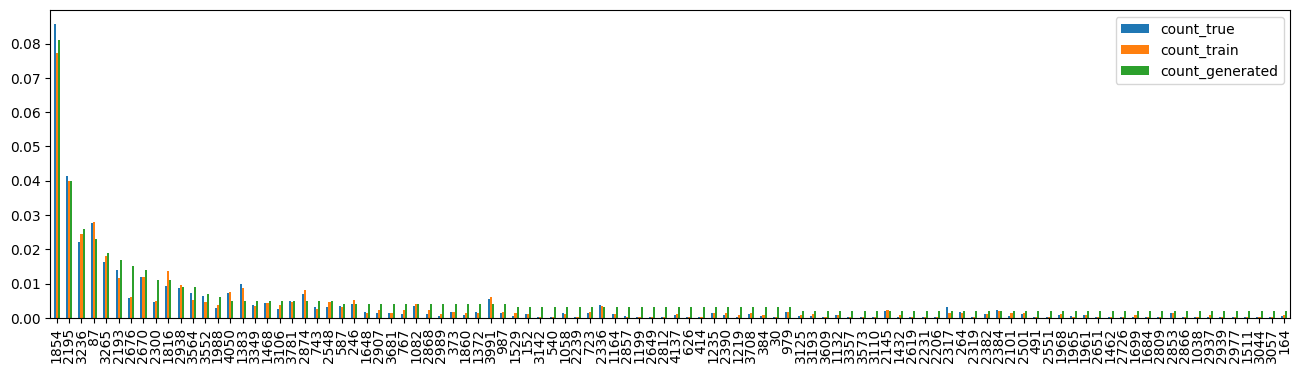

In [85]:
import matplotlib.pyplot as plt
import numpy as np
# Only the top 100 facts graphed for visibility 
comparison_df[:100].plot.bar(figsize=(16, 4))

## Hallucination rates

In [86]:
# True hallucination rate (generations not in true dist)
true_hallucinations = pd.merge(collected_generations_counts, true_duplicates_count, on='facts', how='left')


In [87]:
true_hallucinations

,facts,count_generated,count_true
0,"Abbe,frozen yogurt",1,1.0
1,"Abbi,grilled cheese sandwich",1,1.0
2,"Abbot,escargots",1,1.0
3,"Abbot,tiramisu",1,1.0
4,"Abbye,takoyaki",1,2.0
...,...,...,...
527,"spaghetti bolognese ,macarons",1,NaN
528,"spaghetti carbonara ,Robbyn",1,NaN
529,"spaghetti carbonara ,Shaina",1,NaN
530,"spring rolls ,Virgina",1,NaN


In [88]:
true_hallucinations = true_hallucinations.fillna(0)
number_of_true_hallucinations =true_hallucinations["count_true"].value_counts()[0]
true_hallucinations_rate = number_of_true_hallucinations / len(collected_generations)
print(f"Rate of true hallucinations: {true_hallucinations_rate} ")

Rate of true hallucinations: 0.048 


In [89]:
# Naive hallucination rate (every generation not in training data)
naive_hallucinations = pd.merge(collected_generations_counts, training_duplicates_count, on='facts', how='left')

In [90]:
naive_hallucinations

,facts,count_generated,count_train
0,"Abbe,frozen yogurt",1,1.0
1,"Abbi,grilled cheese sandwich",1,1.0
2,"Abbot,escargots",1,1.0
3,"Abbot,tiramisu",1,1.0
4,"Abbye,takoyaki",1,2.0
...,...,...,...
527,"spaghetti bolognese ,macarons",1,NaN
528,"spaghetti carbonara ,Robbyn",1,NaN
529,"spaghetti carbonara ,Shaina",1,NaN
530,"spring rolls ,Virgina",1,NaN


In [91]:
naive_hallucinations = naive_hallucinations.fillna(0)
number_of_naive_hallucinations = naive_hallucinations["count_train"].value_counts()[0]
naive_hallucinations_rate = number_of_naive_hallucinations / len(collected_generations)
print(f"Rate of naive hallucinations: {naive_hallucinations_rate} ")

Rate of naive hallucinations: 0.049 


### Monofact rate

In [117]:
MF = training_duplicates_count["count_train"].value_counts()[1] / len(training_data)
MF

0.44866666666666666

In [116]:
training_duplicates_count["count_train"].value_counts()[1]

1346

### Miscalibration

In [94]:
from lib.calibration import miscalibration

In [95]:
comparison_sorted_by_generated = comparison_df.sort_values(by='count_generated', ascending=False)

In [96]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_true'])

Adaptive binning with 12 bins
bin with g_proba / p_proba 0.081 0.0856
bin with g_proba / p_proba 0.066 0.0635
bin with g_proba / p_proba 0.074 0.06359999999999999
bin with g_proba / p_proba 0.08200000000000002 0.061900000000000004
bin with g_proba / p_proba 0.08200000000000005 0.062
bin with g_proba / p_proba 0.08300000000000003 0.024799999999999996
bin with g_proba / p_proba 0.08200000000000006 0.0243
bin with g_proba / p_proba 0.08300000000000006 0.0156
bin with g_proba / p_proba 0.08300000000000006 0.0177
bin with g_proba / p_proba 0.08300000000000006 0.018799999999999994
bin with g_proba / p_proba 0.08300000000000006 0.0179
bin with g_proba / p_proba 0.08300000000000006 0.023200000000000002
bin with g_proba / p_proba 0.035000000000000024 0.5211000000000001


0.5313028044280442

In [97]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_train'])

Adaptive binning with 12 bins
bin with g_proba / p_proba 0.081 0.07733333333333334
bin with g_proba / p_proba 0.066 0.06433333333333333
bin with g_proba / p_proba 0.074 0.06366666666666666
bin with g_proba / p_proba 0.08200000000000002 0.066
bin with g_proba / p_proba 0.08200000000000005 0.06833333333333334
bin with g_proba / p_proba 0.08300000000000003 0.030333333333333334
bin with g_proba / p_proba 0.08200000000000006 0.030000000000000002
bin with g_proba / p_proba 0.08300000000000006 0.02733333333333334
bin with g_proba / p_proba 0.08300000000000006 0.030333333333333337
bin with g_proba / p_proba 0.08300000000000006 0.03266666666666666
bin with g_proba / p_proba 0.08300000000000006 0.03133333333333334
bin with g_proba / p_proba 0.08300000000000006 0.039333333333333324
bin with g_proba / p_proba 0.035000000000000024 0.439


0.4474335178351783

### Check if it holds

In [107]:
unique_names = len(set([t[1] for t in train_dataset]))
unique_foods = len(set([t[2] for t in train_dataset]))
# Possible generations
POSS_GENERATIONS = unique_names * unique_foods

# Facts to all possibilities - facts, approximated
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS = 300 * len(training_duplicates_count) / (POSS_GENERATIONS - len(training_duplicates_count))

In [118]:
HALLUCINATION_RATE = true_hallucinations_rate

#MF = 0.43875

MISCALIBRATION = 0.2891

In [119]:
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

0.05320943580661637

In [120]:
MF - MISCALIBRATION

0.15956666666666663

In [121]:
7 / np.sqrt(len(training_data))

0.12780193008453875

In [122]:
MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

-0.02144469922448848

In [123]:
HALLUCINATION_RATE

0.048

In [124]:
HALLUCINATION_RATE > MF - MISCALIBRATION

False

In [125]:
HALLUCINATION_RATE > MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

True